<a href="https://colab.research.google.com/github/dude123studios/AdvancedGenerativeLearning/blob/main/Variational_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow_probability  import distributions as tfd
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Layer, Input, Conv2D, Dense, Flatten, Reshape, Lambda, Dropout
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, UpSampling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
(ds_train, ds_test_), ds_info = tfds.load('mnist', 
                              split=['train', 'test'], 
                              shuffle_files=True,
                              as_supervised=True,
                              with_info=True)


batch_size = 256
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = image/255.
    return image, image


ds_train = ds_train.map(preprocess)
ds_train = ds_train.cache() # put dataset into memory
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)

ds_test = ds_test_.map(preprocess).batch(batch_size).cache().prefetch(batch_size)

In [ ]:
def preprocess_with_label(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.math.round(image/255.)
    return image, label

ds_test_label = ds_test_.map(preprocess_with_label).batch(1000)

In [ ]:
class GaussianSampling(Layer):

    def call(self, inputs):

        means, logvar = inputs
        epsilon = tf.random.normal(shape=tf.shape(means))
        samples = means + tf.exp(logvar * 0.5) * epsilon

        return samples

In [ ]:
class Encoder(Layer):

    def __init__(self, z_dim, name='encoder'):
        super(Encoder, self).__init__()

        self.features_extract = Sequential([
            Conv2D(filters=8, kernel_size=(3, 3), strides=2, padding="same", activation='relu'),
            Conv2D(filters=8, kernel_size=(3, 3), strides=1, padding="same", activation='relu'),
            Conv2D(filters=8, kernel_size=(3, 3), strides=2, padding="same", activation='relu'),
            Conv2D(filters=8, kernel_size=(3, 3), strides=1, padding="same", activation='relu'),
            Flatten()
        ])

        self.dense_mean = Dense(z_dim, name='mean')
        self.dense_logvar = Dense(z_dim, name='logvar')
        self.sampler = GaussianSampling()
    
    def call(self, inputs):

        x = self.features_extract(inputs)
        mean = self.dense_mean(x)
        logvar = self.dense_logvar(x)

        z = self.sampler([mean, logvar])
        
        return z, mean, logvar

In [ ]:
class Decoder(Layer):

    def __init__(self, z_dim, name='decoder'):
        super(Decoder, self).__init__()

        self.forward = Sequential([
            Dense(7*7*64, activation='relu'),
            Reshape((7, 7, 64)),
            Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
            UpSampling2D((2, 2)),
            Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
            UpSampling2D((2, 2)),
            Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='sigmoid'),
        ])

    def call(self, inputs):
        return self.forward(inputs)

In [ ]:
class VAE(Model):

    def __init__(self, z_dim, name="VAE"):
        super(VAE, self).__init__()

        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)

        self.mean = None
        self.logvar = None
    
    def call(self, inputs):
        z, self.mean, self.logvar = self.encoder(inputs)
        return self.decoder(z)

In [ ]:
vae = VAE(2)

def kl_loss(y_true, y_pred):
    loss = -0.5 * tf.reduce_mean(1 + vae.logvar - tf.square(vae.mean) - tf.exp(vae.logvar))
    return loss

def rc_loss(y_true, y_pred):
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return loss

def vae_loss(y_true, y_pred):
    kl_loss_val = kl_loss(y_true, y_pred)
    rc_loss_val = rc_loss(y_true, y_pred)
    return 1e-2 * kl_loss_val + rc_loss_val

In [ ]:
model_path = "./models/vae.h5"
checkpoint = ModelCheckpoint(model_path, 
                             monitor= "rc_loss", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "auto", 
                             save_weights_only = True)

early = EarlyStopping(monitor= "rc_loss", 
                      mode= "auto", 
                      patience = 5)

callbacks_list = [checkpoint, early]

vae.compile(loss=vae_loss, optimizer=tf.keras.optimizers.Adam(1e-3), metrics=[kl_loss, rc_loss])

vae.fit(ds_train, validation_data=ds_test, epochs=50, callbacks=callbacks_list)

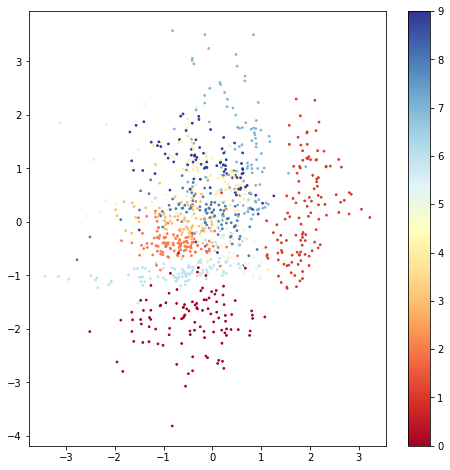

In [ ]:
vae.load_weights(model_path)
images, labels = next(iter(ds_test_label))
outputs, z_means, z_vars = vae.encoder(images)
plt.figure(figsize=(8, 8))
plt.scatter(outputs[:, 0], outputs[:, 1], c=labels, cmap='RdYlBu', s=3)
plt.colorbar()

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def explore_latent_variable(z1 = (-5,5,0.1),
                            z2 = (-5,5,0.1)):
    z_samples = np.array([[z1, z2]], dtype=np.float32)
    images = vae.decoder(z_samples)
    plt.figure(figsize=(2,2))
    plt.imshow(images[0,:,:,0], cmap='gray')

interactive(children=(FloatSlider(value=0.0, description='z1', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…

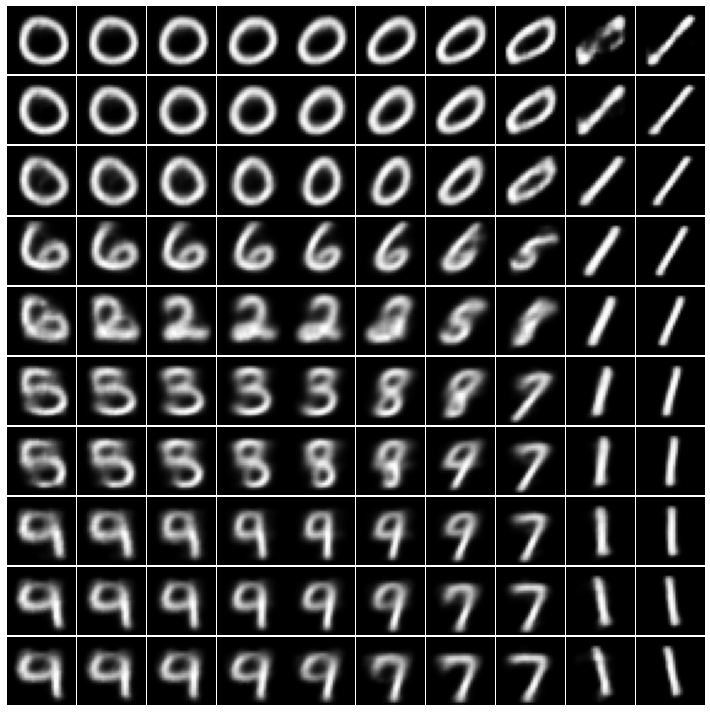

In [ ]:
z_samples = np.array([[z1, z2] for z2 in np.arange(-2.5,2.5,0.5) for z1 in np.arange(-2.5,2.5,0.5)], dtype=np.float32)
images = vae.decoder(z_samples)
grid_col = 10
grid_row = 10

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col, grid_row))

i = 0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row,col].axis('off')   
        i += 1
f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)        
plt.show()